In [3]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

(<matplotlib.axes._subplots.AxesSubplot at 0x19b315c2630>,
 Text(0.5, 1.0, 'center'))

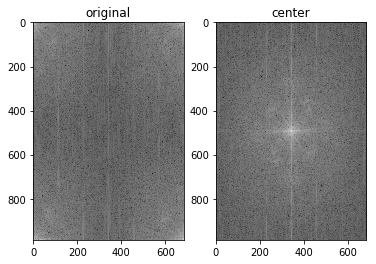

In [6]:
img = cv2.imread('images/color_image.jpg',0) #直接读为灰度图像
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
s1 = np.log(np.abs(f)) 
s2 = np.log(np.abs(fshift)) 
plt.subplot(121),plt.imshow(s1,'gray'),plt.title('original') 
plt.subplot(122),plt.imshow(s2,'gray'),plt.title('center')
